<a href="https://colab.research.google.com/github/jmoriwa/vae_recommender_system/blob/main/vae_recommender_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import pandas as pd
import numpy as np
import random
import pickle
from scipy import sparse

### Load and Read Data

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
ratings_path = "/content/drive/MyDrive/archive/rating.csv"
movies_path = "/content/drive/MyDrive/archive/movie.csv"

In [15]:
raw_data = pd.read_csv(ratings_path)

In [16]:
unique_user_ids = raw_data.userId.unique()

In [17]:
np.random.seed(1)
np.random.shuffle(unique_user_ids) # to ensure random splitting between train, val and test
unique_movie_ids = raw_data.movieId.unique()

In [18]:
number_of_users = len(unique_user_ids)
print("total number of users: ", number_of_users)

number_of_movies = len(unique_movie_ids)
print("total number of movies: ", number_of_movies)

total number of users:  138493
total number of movies:  26744


## Split users into training,test and validation

In [19]:
val_user_ids = []
test_user_ids = []
train_user_ids = []

for i in range(10000):
    val_user_ids.append(unique_user_ids[i]) # first 10k after shuffling keys

for i in range(10000, 20000):
    test_user_ids.append(unique_user_ids[i]) # next 10k after shuffling keys

for i in range(20000, number_of_users): # all the remaining form training data
    train_user_ids.append(unique_user_ids[i])

## Create an Sparse matrix for traing,test and validation set for interaction

In [22]:
# creating a movieId and userId to index dictionary for creating train_data ndarray
movie2id = {mid: i for i, mid in enumerate(unique_movie_ids)}

user2id = {uid: i for i, uid in enumerate(train_user_ids)}
test_user2id = {uid: i for i, uid in enumerate(test_user_ids)}
val_user2id = {uid: i for i, uid in enumerate(val_user_ids)}


In [23]:
# Pre-filter and group data once
filtered_data = raw_data[raw_data.rating > 3.5]
grouped_data = filtered_data.groupby('userId')['movieId'].apply(list).to_dict()

In [24]:
def create_sparse_matrix(user_ids, user2id_map, filename):
    rows = []
    cols = []

    for u_id in user_ids:
        movie_ids = grouped_data.get(u_id, [])
        movie_indexes = [movie2id[m] for m in movie_ids if m in movie2id]
        rows.extend([user2id_map[u_id]] * len(movie_indexes))
        cols.extend(movie_indexes)

    data = sparse.csr_matrix(
        (np.ones_like(rows), (np.array(rows), np.array(cols))),
        dtype='float64',
        shape=(len(user_ids), len(movie2id))
    )

    pickle.dump(data, open(filename, "wb"))
    print(f"{filename} created with {len(user_ids)} users.")

In [25]:
# Create datasets
create_sparse_matrix(train_user_ids, user2id, "train_data.file")


train_data.file created with 118493 users.


In [26]:
create_sparse_matrix(test_user_ids, test_user2id, "test_data.file")

test_data.file created with 10000 users.


In [27]:
create_sparse_matrix(val_user_ids, val_user2id, "val_data.file")

val_data.file created with 10000 users.


### VAE Model

In [28]:
import numpy as np
import pickle
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, Callback
from tensorflow.keras.losses import binary_crossentropy
from scipy import sparse
from tqdm import tqdm

In [85]:
class LossHistory(Callback):
    def on_train_begin(self, logs=None):
        self.losses = []
        self.val_losses = []

    def on_epoch_end(self, epoch, logs=None):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

history = LossHistory()

In [99]:
# Parameters
batch_size = 512
original_dim = x_train.shape[1]
intermediate_dim = 1000
latent_dim = 400
nb_epochs = 25
epsilon_std = 1.0

In [100]:
# Encoder
x_input = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='tanh')(x_input)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

In [101]:
# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

z = Lambda(sampling)([z_mean, z_log_var])

In [102]:
# Decoder
h_decoder = Dense(intermediate_dim, activation='tanh')
x_bar = Dense(original_dim, activation='softmax')
h_decoded = h_decoder(z)
x_decoded = x_bar(h_decoded)

# VAE Model
vae = Model(x_input, x_decoded)


In [103]:
class KLDivergenceLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
        self.add_loss(tf.reduce_mean(kl_loss))
        return inputs

# Apply KL divergence custom layer
[z_mean, z_log_var] = KLDivergenceLayer()([z_mean, z_log_var])

# Compile model
def reconstruction_loss(y_true, y_pred):
    return original_dim * binary_crossentropy(y_true, y_pred)

vae.compile(optimizer='adam', loss=reconstruction_loss)

In [104]:
# Load data
x_train = pickle.load(open("train_data.file", "rb"))
x_val = pickle.load(open("val_data.file", "rb"))

print("Training users:", x_train.shape[0])
print("Validation users:", x_val.shape[0])

Training users: 118493
Validation users: 10000


In [105]:
def nn_batch_generator(x, batch_size):
    indices = np.arange(x.shape[0])
    while True:
        np.random.shuffle(indices)
        for start_idx in range(0, len(indices), batch_size):
            end_idx = min(start_idx + batch_size, len(indices))
            batch_indices = indices[start_idx:end_idx]
            x_batch = x[batch_indices].todense()  # Convert sparse to dense
            yield np.array(x_batch), np.array(x_batch)

In [106]:
# Callbacks
weights_path = "./tmp/vae_model.keras"
checkpointer = ModelCheckpoint(filepath=weights_path, verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# Training
steps_per_epoch = x_train.shape[0] // batch_size

In [107]:
vae.fit(
    nn_batch_generator(x_train, batch_size),
    steps_per_epoch=steps_per_epoch,
    epochs=nb_epochs,
    validation_data=(x_val.todense(), x_val.todense()),
    callbacks=[checkpointer, reduce_lr, history],
    verbose=1
)

# Losses
print("Training losses over epochs:", history.losses)
print("Validation losses over epochs:", history.val_losses)

Epoch 1/25
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - loss: 2094.1738
Epoch 1: val_loss improved from inf to 278.85864, saving model to ./tmp/vae_model.keras
231/231 ━━━━━━━━━━━━━━━━━━━━ 79s 298ms/step - loss: 2088.0811 - val_loss: 278.8586 - learning_rate: 0.0010
Epoch 2/25
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 271.2531
Epoch 2: val_loss improved from 278.85864 to 264.50510, saving model to ./tmp/vae_model.keras
231/231 ━━━━━━━━━━━━━━━━━━━━ 68s 253ms/step - loss: 271.2358 - val_loss: 264.5051 - learning_rate: 0.0010
Epoch 3/25
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - loss: 257.6168
Epoch 3: val_loss improved from 264.50510 to 247.36975, saving model to ./tmp/vae_model.keras
231/231 ━━━━━━━━━━━━━━━━━━━━ 58s 253ms/step - loss: 257.6025 - val_loss: 247.3698 - learning_rate: 0.0010
Epoch 4/25
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - loss: 242.0823
Epoch 4: val_loss improved from 247.36975 to 235.29276, saving model to ./tmp/vae_model.keras
231/231 ━━━━━━━━━━━━━━━━━━

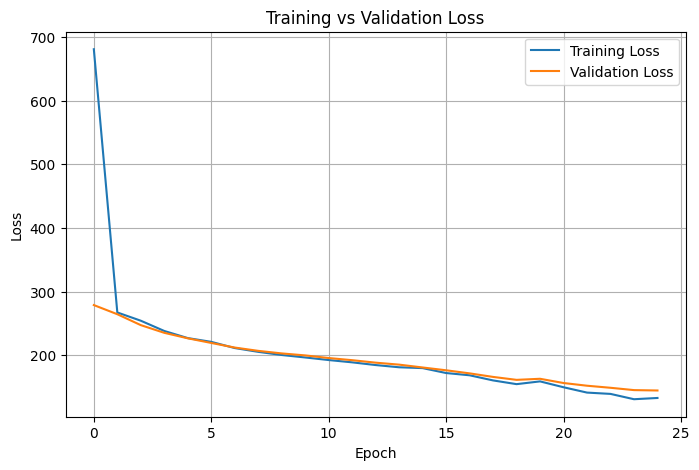

In [108]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8,5))
plt.plot(history.losses, label='Training Loss')
plt.plot(history.val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

### Evaluation

In [109]:
import numpy as np
import math

# ---------- Predict on Test Set ----------
# Convert x_test (sparse) to dense and predict with VAE
x_test_matrix = pickle.load(open("test_data.file", "rb"))
x_test_dense = np.asarray(x_test_matrix.todense())
x_test_reconstructed = vae.predict(x_test_dense)

print("Test data loaded. Shape:", x_test_dense.shape)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
Test data loaded. Shape: (10000, 26744)


In [110]:
def recallatk(x_test, x_test_reconstructed, k):
    recall_values = []
    for i in range(len(x_test)):
        true_items = [idx for idx, val in enumerate(x_test[i].tolist()) if val == 1.0]
        if len(true_items) == 0:
            continue  # Skip users with no positive interactions

        predicted_scores = x_test_reconstructed[i].tolist()
        top_k_predicted = sorted(range(len(predicted_scores)), key=lambda x: predicted_scores[x], reverse=True)[:k]

        hits = len(set(top_k_predicted) & set(true_items))
        recall = hits / min(k, len(true_items))
        recall_values.append(recall)

    return np.mean(recall_values)

def ndcgatk(x_test, x_test_reconstructed, k):
    ndcg_values = []
    for i in range(len(x_test)):
        true_items = [idx for idx, val in enumerate(x_test[i].tolist()) if val == 1.0]
        if len(true_items) == 0:
            continue  # Skip users with no positive interactions

        predicted_scores = x_test_reconstructed[i].tolist()
        top_k_predicted = sorted(range(len(predicted_scores)), key=lambda x: predicted_scores[x], reverse=True)[:k]

        dcg = 0.0
        for rank, idx in enumerate(top_k_predicted):
            if idx in true_items:
                dcg += 1 / math.log2(rank + 2)

        # Ideal DCG
        idcg = sum(1 / math.log2(rank + 2) for rank in range(min(len(true_items), k)))
        ndcg = dcg / idcg if idcg > 0 else 0
        ndcg_values.append(ndcg)

    return np.mean(ndcg_values)

In [111]:
print("Recall@20:", recallatk(x_test_dense, x_test_reconstructed, 20))
print("Recall@50:", recallatk(x_test_dense, x_test_reconstructed, 50))
print("NDCG@100:", ndcgatk(x_test_dense, x_test_reconstructed, 100))

Recall@20: 0.8858893091737405
Recall@50: 0.8386962003117945
NDCG@100: 0.8576853274328555


### Recommendations

In [118]:
movies_df = pd.read_csv(movies_path)


movie_titles = dict(zip(movies_df['movieId'], movies_df['title']))

unique_movie_ids = sorted(movies_df['movieId'].unique())
movie_id_map = {index: movieId for index, movieId in enumerate(unique_movie_ids)}


In [119]:
num_users = x_test_dense.shape[0]
random_user_indices = random.sample(range(num_users), 10)


for user_idx in random_user_indices:
    user_interactions = x_test_dense[user_idx]  # Actual interactions
    user_predictions = x_test_reconstructed[user_idx]

    # Mask already interacted items
    user_predictions[user_interactions == 1] = -np.inf

    # Top-10 recommendations
    top_10_items = np.argsort(user_predictions)[-10:][::-1]  # Descending order

    movie_ids = [movie_id_map[i] for i in top_10_items]
    titles = [movie_titles[mid] for mid in movie_ids]

    print(f"User {user_idx} Top-10 Movie Titles: {titles}")

User 7226 Top-10 Movie Titles: ['Naked in New York (1994)', 'Panther (1995)', 'Quick and the Dead, The (1995)', 'Signs & Wonders (2001)', 'Queen Margot (Reine Margot, La) (1994)', 'Arrival, The (1996)', 'Ace Ventura: Pet Detective (1994)', 'Crow, The (1994)', 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)', 'Cry, the Beloved Country (1995)']
User 4987 Top-10 Movie Titles: ['Gangster No. 1 (2000)', 'Anna and the King of Siam (1946)', 'Dangerous Lives of Altar Boys, The (2002)', "Preacher's Wife, The (1996)", 'Lady Jane (1986)', 'Getting It Right (1989)', 'Cast a Giant Shadow (1966)', 'Married to the Mob (1988)', 'They (2002)', 'Last Tango in Paris (Ultimo tango a Parigi) (1972)']
User 2680 Top-10 Movie Titles: ['True Lies (1994)', 'Sexual Life of the Belgians, The (Vie sexuelle des Belges 1950-1978, La) (1994)', 'Fall Time (1995)', 'Breakdown (1997)', 'Firestorm (1998)', 'River Wild, The (1994)', 'Colonel Chabert, Le (1994)', 'Above the Rim (1994)', '8 Seconds (1994)', 'Quest, The (1996)']
